In [7]:

# Importation des bibliothèques nécessaires
import yfinance as yf
import pywt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import mplfinance as mpf
    

In [8]:

# Étape 1 : Récupération des données de Bitcoin
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2024-06-10')
btc_close = btc_data['Close']
    

[*********************100%%**********************]  1 of 1 completed


In [9]:

# Étape 2 : Décomposition des données en ondelettes avec db4
coeffs = pywt.wavedec(btc_close, 'db4', level=3)
A3, D3, D2, D1 = coeffs

# Reconstituer les approximations pour chaque niveau
A2 = pywt.upcoef('a', A3, 'db4', level=2, take=len(D2))
A1 = pywt.upcoef('a', A3, 'db4', level=1, take=len(D1))

# Fonction pour créer un graphique pour chaque niveau de décomposition
def plot_wavelet_level(btc_close, approx, detail, level):
    fig = go.Figure()

    # Add the original closing prices
    fig.add_trace(go.Scatter(x=btc_data.index, y=btc_close, mode='lines', name='Prix de Clôture Bitcoin', line=dict(color='blue')))

    # Add the wavelet decompositions
    fig.add_trace(go.Scatter(x=btc_data.index, y=approx, mode='lines', name=f'Approximation Niveau {level} (A{level})', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=btc_data.index, y=detail, mode='lines', name=f'Détail Niveau {level} (D{level})', line=dict(color='green')))

    fig.update_layout(title=f'Décomposition des Composantes de Bitcoin - Niveau {level}', xaxis_title='Date', yaxis_title='Valeur', template='plotly_dark')
    fig.show()

# Visualisation des niveaux de décomposition
plot_wavelet_level(btc_close, A1, D1, 1)
plot_wavelet_level(btc_close, A2, D2, 2)
plot_wavelet_level(btc_close, A3, D3, 3)
    

In [10]:

# Étape 4 : Prédiction des Composantes Décomposées avec LPC
def predict_lpc(series, order, n_predict):
    X = np.array([series[i:i+order] for i in range(len(series)-order)])
    y = series[order:]
    model = LinearRegression()
    model.fit(X, y)
    preds = list(series[-order:])
    for _ in range(n_predict):
        preds.append(model.predict([preds[-order:]])[0])
    return np.array(preds[-n_predict:])

n_predict = 60  # Adjusted to predict 60 days
lpc_order = 5

predicted_A3_lpc = predict_lpc(A3, lpc_order, n_predict)
predicted_D3_lpc = predict_lpc(D3, lpc_order, n_predict)
predicted_D2_lpc = predict_lpc(D2, lpc_order, n_predict)
predicted_D1_lpc = predict_lpc(D1, lpc_order, n_predict)

# Ajuster les formes des coefficients prévus pour correspondre aux formes d'origine
def adjust_coeff_shape(original, predicted):
    if len(predicted) > len(original):
        return predicted[:len(original)]
    else:
        return np.concatenate([predicted, np.zeros(len(original) - len(predicted))])

predicted_A3_lpc = adjust_coeff_shape(A3, predicted_A3_lpc)
predicted_D3_lpc = adjust_coeff_shape(D3, predicted_D3_lpc)
predicted_D2_lpc = adjust_coeff_shape(D2, predicted_D2_lpc)
predicted_D1_lpc = adjust_coeff_shape(D1, predicted_D1_lpc)
    

In [11]:

# Étape 5 : Reconstruction des prévisions à partir des composants prévus
future_lpc = pywt.waverec([predicted_A3_lpc] + [predicted_D3_lpc, predicted_D2_lpc, predicted_D1_lpc], 'db4')

# Correction des longueurs pour les séries futures
future_lpc = future_lpc[:n_predict]

# Générer les bonnes dates futures pour correspondre aux longueurs des prévisions
btc_future_dates = pd.date_range(start=btc_data.index[-1] + pd.Timedelta(days=1), periods=n_predict, freq='D')

# Ajouter les prévisions aux données originales pour les graphiques
future_df = pd.DataFrame(index=btc_future_dates, columns=btc_data.columns)
future_df['Close'] = np.nan
btc_extended = pd.concat([btc_data, future_df])

btc_extended['Pred_LPC'] = np.nan

# Assigner les prévisions futures
btc_extended.loc[btc_future_dates, 'Pred_LPC'] = future_lpc
    

C:\Users\home\AppData\Local\Temp\ipykernel_14192\694471566.py:13: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



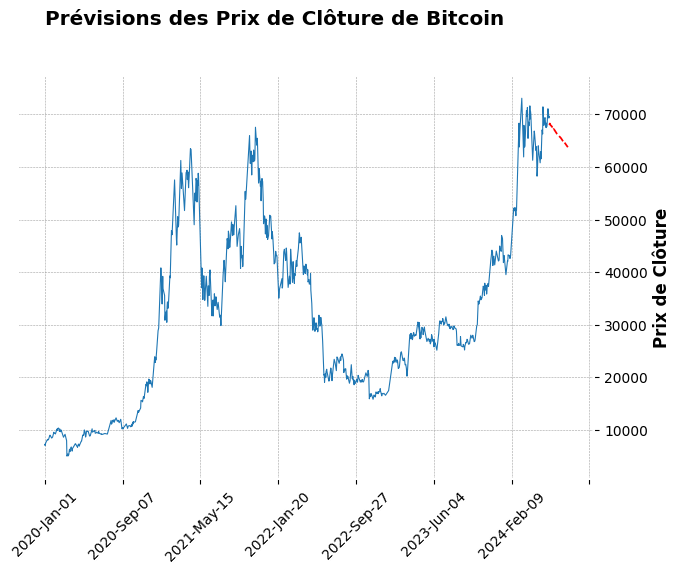

In [12]:

# Étape 6 : Visualisation des Résultats avec Plotly
fig = go.Figure()

# Add the original closing prices
fig.add_trace(go.Scatter(x=btc_data.index, y=btc_close, mode='lines', name='Prix Historique', line=dict(color='blue')))

# Add the predicted LPC values
fig.add_trace(go.Scatter(x=btc_future_dates, y=future_lpc, mode='lines', name='Prévisions LPC', line=dict(color='red', dash='dash')))

fig.update_layout(title='Prévisions des Prix de Clôture de Bitcoin', xaxis_title='Date', yaxis_title='Prix de Clôture', template='plotly_dark')
fig.show()

# Graphiques mplfinance en utilisant le type 'line' pour éviter l'avertissement
mpf.plot(btc_extended, type='line', style='charles',
         title='Prévisions des Prix de Clôture de Bitcoin',
         ylabel='Prix de Clôture',
         addplot=[
             mpf.make_addplot(btc_extended['Pred_LPC'], color='red', linestyle='dashed')
         ])
    